In [2]:
import os, importlib, sys, time

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import scipy.linalg as la
import scipy.stats as stats

In [5]:
save_dir = "result_epidemia"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [7]:
data = pd.read_csv('data/EuropeCovid2.csv', index_col=0)

In [8]:
GPi = np.load('data/GPi.npz')

In [9]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [10]:
regions = np.array(data['id'].unique())
regions = regions[regions != 'SE']

In [11]:
regions

array(['AT', 'BE', 'DK', 'FR', 'DE', 'IT', 'NO', 'ES', 'CH', 'GB'],
      dtype=object)

In [12]:
d = 2

In [13]:
Ys_raw = np.array([data[data.id == r].deaths for r in regions])
As_raw = np.array([data[data.id == r].lockdown for r in regions])
POIs = np.nancumsum(Ys_raw, 1) > 10
Ts = np.sum(POIs, 1)

In [14]:
Ts

array([100, 108, 101, 114, 107, 126,  97, 114, 111, 108])

In [15]:
# Ys_raw = np.where(
#     np.isnan(Ys_raw),
#     (np.roll(Ys_raw, 1, 1) + np.roll(Ys_raw, -1, 1))/2,
#     Ys_raw)

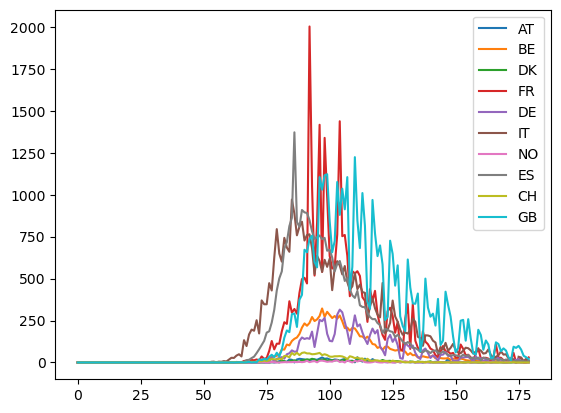

In [16]:
for Y_raw, POI, r in zip(Ys_raw, POIs, regions):
    plt.plot(Y_raw, label=r)
plt.legend()
plt.show()

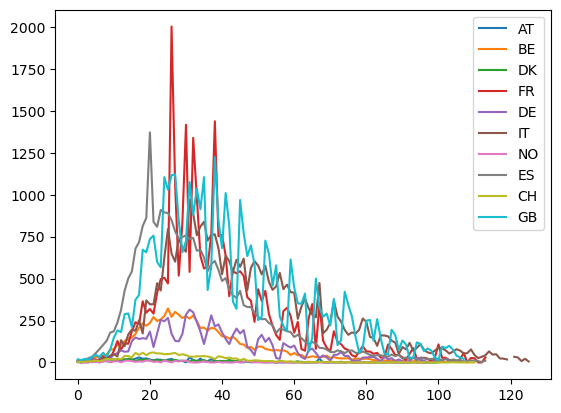

In [17]:
for Y_raw, POI, r in zip(Ys_raw, POIs, regions):
    plt.plot(Y_raw[POI], label=r)
plt.legend()
plt.show()

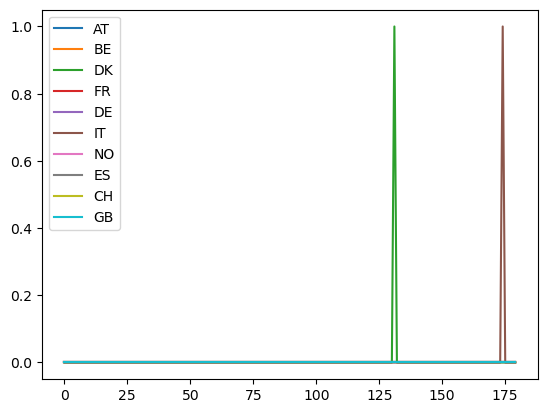

In [18]:
plt.plot(np.isnan(Ys_raw).T, label=regions)
plt.legend()
plt.show()

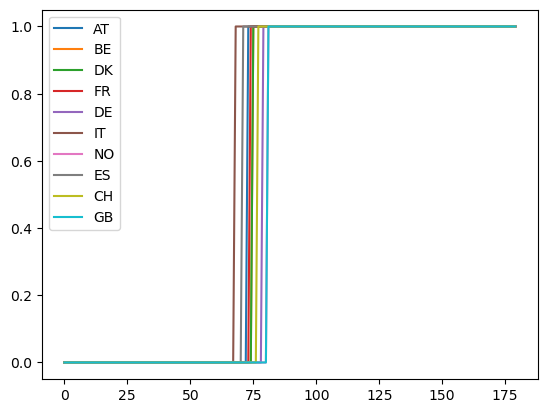

In [19]:
for A_raw, POI, r in zip(As_raw, POIs, regions):
    plt.plot(A_raw, label=r)
plt.legend()
plt.show()

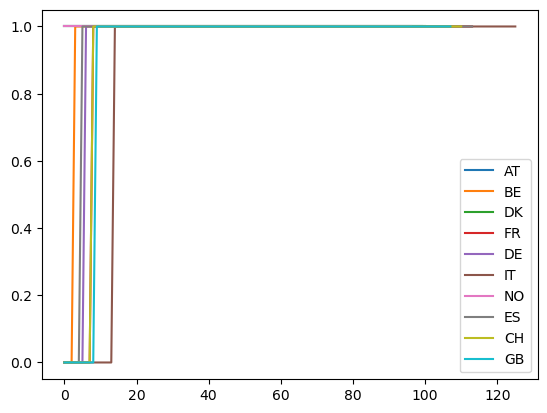

In [20]:
for A_raw, POI, r in zip(As_raw, POIs, regions):
    plt.plot(A_raw[POI], label=r)
plt.legend()
plt.show()

In [21]:
T0 = 20
alpha = 1
K = 6.5

# 3. EM algorithm

In [22]:
def NBLL(y, m, r):
    if np.isnan(y):
        return 0
    else:
        y = int(y)
        return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
                + r * np.log(r/(r+m)) 
                + y * np.log(m/(r+m)))

In [23]:
def dNBLLdr(y, m, r):
    if np.isnan(y):
        return 0
    else:
        y = int(y)
        return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [24]:
def d2NBLLdr2(y, m, r):
    if np.isnan(y):
        return 0
    else:
        y = int(y)
        return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [25]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat= np.array(binit)
    ss = np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(- bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = np.where(
            np.isnan(obs), 0,
            obs/EY - (rhat+obs)/(rhat+EY))
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = np.where(
            np.isnan(obs), 0,
            - obs/EY**2 + (rhat+obs)/(rhat+EY)**2)
        d2ldrdEY = np.where(
            np.isnan(obs), 0,
            - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2)

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/1000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = rhat + ss * dth[0]
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(- bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

# 4. estimate + inference

In [28]:
rinit = 5
minit_0 = 20
binit = [0, -2]

In [29]:
for i, (r, Y_raw, A_raw, POI) \
in enumerate(zip(regions, Ys_raw, As_raw, POIs)):
    start_region = time.time()
    sys.__stdout__.write("Program at %s started \n"%r)
    sys.__stdout__.flush()  
    
    # data
    T = np.sum(POI)
    Y = Y_raw[POI]
    A = np.zeros([T+T0, d])
    A[:,0] = np.full(T+T0, 1)
    A[T0:,1] = A_raw[POI]
    
    # g
    g = np.zeros(T+T0)
    g[:GPi['g'].shape[0]] = GPi['g']
    
    # pi
    pi = np.zeros(T+T0)
    pi[:GPi['pi'].shape[0]] = GPi['pi']
    
    # fit
    rhs, mhs_0, bhs =\
    fit(Y, rinit, minit_0, binit, 
        history=True, verbose=False, n_iter=10000, step_size=1)
    
    sys.__stdout__.write("Estimation at %s finished, lapse: %f sec. \n"
                     %(r, time.time() - start_region))
    sys.__stdout__.flush()  
    
    # collect MLEs
    rmle = rhs[-1]
    mmle_0 = mhs_0[-1]
    bmle = bhs[-1]
    
    Rmle = np.zeros(T+T0)
    d1Rm = np.zeros([d, T+T0])
    d2Rm = np.zeros([d, d, T+T0])
    for t in np.arange(T+T0):
        o = np.exp(- bmle @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rmle[t] = K * p
        d1Rm[:,t] = K * p * q * A[t]
        d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])
    
    # Wald's confidence region
    Pi = alpha * np.concatenate([[0],pi])[
        np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rmle[:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mmle_0 * Pi_inv_ImG[:,0]
    d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
    d2EY = mmle_0 * (Pi_inv_ImG @ (
        d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
        + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
        + d2G @ inv_ImG[:,:1]))[...,0]
    
    dldEY = np.where(
        np.isnan(Y), 0,
        Y/EY - (rmle+Y)/(rmle+EY))
    d2ldEY2 = np.where(
        np.isnan(Y), 0,
        - Y/EY**2 + (rmle+Y)/(rmle+EY)**2)
    d2ldrdEY = np.where(
        np.isnan(Y), 0,
        - 1/(rmle+EY) + (rmle+Y)/(rmle+EY)**2)
    
    d2ldr2 = np.sum([d2NBLLdr2(y, m, rmle) for y, m in zip(Y, EY)])
    d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
    d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
           + np.sum(dldEY * d2EY, 2)

    d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
    d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
    d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
            + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
    
    d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                        [d2ldrdm, d2ldm2]])
    d2ldrmdb = np.stack([d2ldrdb, 
                         d2ldmdb])
    
    Ihat_dth = - np.block([[d2ldrm2, d2ldrmdb],
                           [d2ldrmdb.T, d2ldb2]])
    
    # Sandwich estimator
    L_HAC = np.floor(4* (T/100)**(2/9))
    w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)
    
    dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y, EY)])
    dltdm = dldEY * Pi_inv_ImG[:,0]
    dltdb = dldEY * d1EY
    
    dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)
    VEdl = dltdth @ w_HAC @ dltdth.T
    Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth
    
    sys.__stdout__.write("Inference at %s finished, lapse: %f sec. \n"
                     %(r, time.time() - start_region))
    sys.__stdout__.flush() 
    
    # save results
    np.savez('%s/results_nbinom_%s.npz'%(save_dir,r),
             T = T, Y = Y, A = A, g = g, pi = pi, 
             rhs = rhs, mhs_0 = mhs_0, bhs = bhs,
             rmle = rmle, mmle_0 = mmle_0, bmle = bmle, Rmle = Rmle,
             EY = EY, Ihat_dth = Ihat_dth, Ihat_sdw = Ihat_sdw)

Program at AT started 
Estimation at AT finished, lapse: 141.889434 sec. 
Inference at AT finished, lapse: 141.909923 sec. 
Program at BE started 
Estimation at BE finished, lapse: 139.808050 sec. 
Inference at BE finished, lapse: 139.859650 sec. 
Program at DK started 
Estimation at DK finished, lapse: 182.448798 sec. 
Inference at DK finished, lapse: 182.461180 sec. 
Program at FR started 
Estimation at FR finished, lapse: 208.617732 sec. 
Inference at FR finished, lapse: 208.629734 sec. 
Program at DE started 
Estimation at DE finished, lapse: 164.679529 sec. 
Inference at DE finished, lapse: 164.691671 sec. 
Program at IT started 
Estimation at IT finished, lapse: 114.849254 sec. 
Inference at IT finished, lapse: 114.861446 sec. 
Program at NO started 
Estimation at NO finished, lapse: 78.556221 sec. 
Inference at NO finished, lapse: 78.579007 sec. 
Program at ES started 
Estimation at ES finished, lapse: 94.018404 sec. 
Inference at ES finished, lapse: 94.042060 sec. 
Program at C

## convergence check

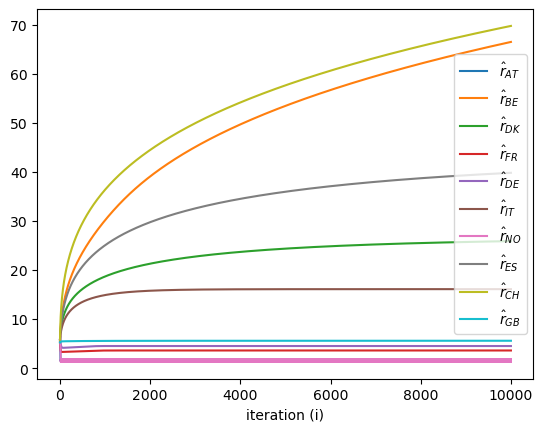

In [30]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    plt.plot(rhs, label=r"$\hat{r}_{%s}$"%r)
plt.xlabel("iteration (i)"); plt.legend()

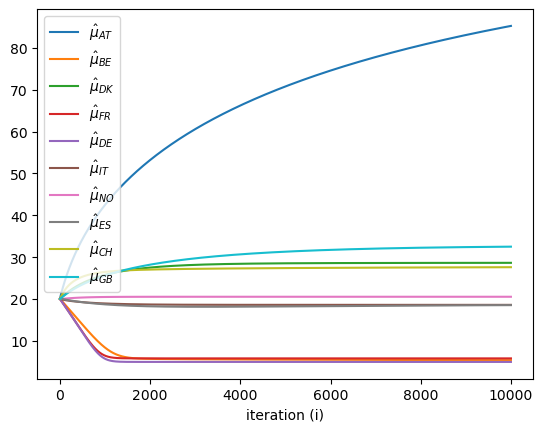

In [31]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    plt.plot(mhs_0, label=r"$\hat{\mu}_{%s}$"%r)
plt.xlabel("iteration (i)"); plt.legend()

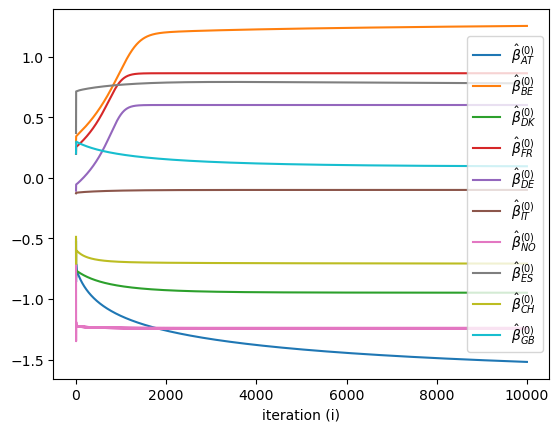

In [32]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    plt.plot(bhs[:,0], label=r"$\hat{\beta}^{(0)}_{%s}$"%r)
plt.xlabel("iteration (i)"); plt.legend()

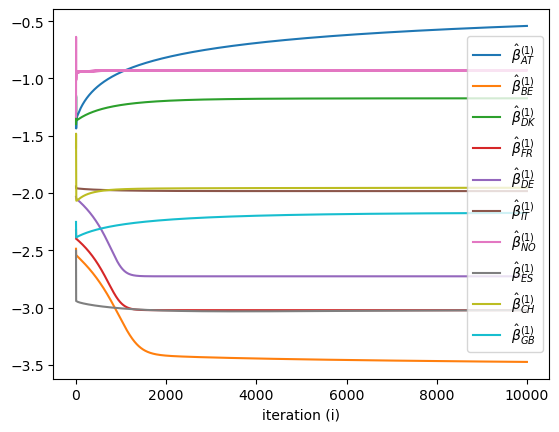

In [33]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    plt.plot(bhs[:,1], label=r"$\hat{\beta}^{(1)}_{%s}$"%r)
plt.xlabel("iteration (i)"); plt.legend()

## plots

In [34]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

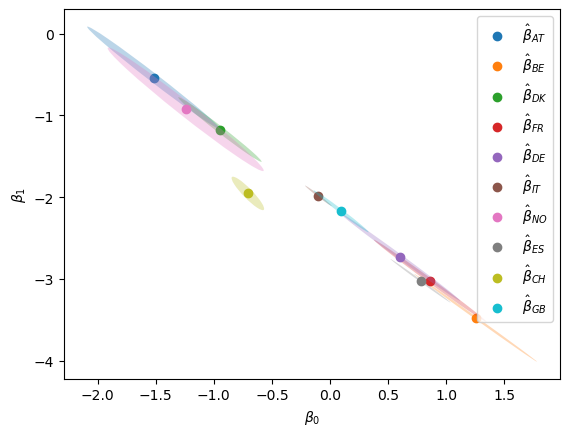

In [35]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    p = ax.scatter(bmle[0], bmle[1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(bmle, np.linalg.pinv(Ihat_dth)[2:,2:], ax, 
                       facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

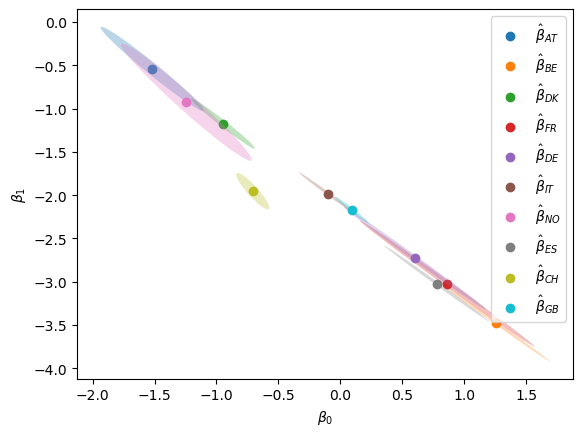

In [37]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    p = ax.scatter(bmle[0], bmle[1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(bmle, np.linalg.pinv(Ihat_sdw)[2:,2:], ax, 
                       facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

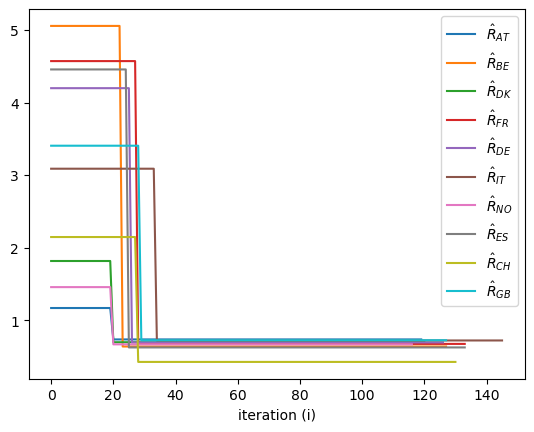

In [38]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    plt.plot(Rmle, label=r"$\hat{R}_{%s}$"%r)
plt.xlabel("iteration (i)"); plt.legend()

# 5. EBCI

In [231]:
import rpy2.robjects as ro
from rpy2.robjects import rl
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [209]:
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [245]:
from rpy2.robjects.packages import importr
from rpy2.robjects.lib.dplyr import DataFrame
ebci = importr('ebci')
base = importr('base')

In [236]:
results_binom=[]
for i, r in enumerate(regions):
    locals().update(np.load('results_nbinom_%s.npz'%r))
    se = np.sqrt(np.diag(np.linalg.pinv(Ihat_dth))[2:])
    sdw = np.sqrt(np.diag(np.linalg.pinv(Ihat_sdw))[2:])
    results_binom.append(
       {'region':r, 'beta_0':bmle[0], 'beta_1':bmle[1],
        'se_0':se[0], 'se_1':se[1], 'sdw_0':sdw[0], 'sdw_1':sdw[1]})

results_binom=pd.DataFrame(results_binom)

In [226]:
# results.to_csv('results_nbinom.csv', index=False)

In [254]:
with localconverter(ro.default_converter + pandas2ri.converter):
    results_summary = base.summary(results_binom)
print(results_summary)

    region              beta_0              beta_1             se_0        
 Length:10          Min.   :-1.518737   Min.   :-3.4730   Min.   :0.05752  
 Class :character   1st Qu.:-0.887580   1st Qu.:-2.9477   1st Qu.:0.12144  
 Mode  :character   Median :-0.002114   Median :-2.0778   Median :0.21104  
                    Mean   :-0.092320   Mean   :-2.0992   Mean   :0.19442  
                    3rd Qu.: 0.735071   3rd Qu.:-1.3682   3rd Qu.:0.26328  
                    Max.   : 1.253537   Max.   :-0.5415   Max.   :0.33592  
      se_1             sdw_0            sdw_1        
 Min.   :0.06244   Min.   :0.0668   Min.   :0.07663  
 1st Qu.:0.12945   1st Qu.:0.1204   1st Qu.:0.12842  
 Median :0.22423   Median :0.2103   Median :0.22219  
 Mean   :0.21036   Mean   :0.1926   Mean   :0.21365  
 3rd Qu.:0.26957   3rd Qu.:0.2530   3rd Qu.:0.28316  
 Max.   :0.37729   Max.   :0.3525   Max.   :0.36343  



In [246]:
with localconverter(ro.default_converter + pandas2ri.converter):
    results_ebci = ro.conversion.rpy2py(
        ebci.ebci(rl('beta_1 ~ 1'), data=results_binom,
                  alpha=0.05, se=rl('se_1'), weights=rl('1/se_1^2'))
        ['df'])
    
    results_ebci_sdw = ro.conversion.rpy2py(
        ebci.ebci(rl('beta_1 ~ 1'), data=results_binom,
                  alpha=0.05, se=rl('sdw_1'), weights=rl('1/sdw_1^2'))
        ['df'])

In [260]:
results_ebci

,w_eb,w_opt,ncov_pa,len_eb,len_op,len_pa,len_us,th_us,th_eb,th_op,se,weights,residuals
0,0.727064,NaN,0.051395,0.526629,NaN,0.523388,0.613815,-0.541503,-0.970088,NaN,0.313177,10.195808,1.570276
1,0.783681,NaN,0.050736,0.467466,NaN,0.465952,0.526347,-3.473032,-3.178566,NaN,0.268549,13.866046,-1.361253
2,0.870272,NaN,0.050195,0.361145,NaN,0.360836,0.386796,-1.173014,-1.294798,NaN,0.197348,25.676295,0.938765
3,0.805566,NaN,0.050553,0.442830,NaN,0.441754,0.492186,-3.021590,-2.844691,NaN,0.251120,15.857578,-0.909811
4,0.781958,NaN,0.050752,0.469356,NaN,0.467803,0.529019,-2.726096,-2.592149,NaN,0.269913,13.726296,-0.614317
5,0.985296,NaN,0.050002,0.121484,NaN,0.121483,0.122387,-1.982632,-1.984531,NaN,0.062443,256.465505,0.129147
6,0.647325,NaN,0.052904,0.602661,NaN,0.594951,0.739469,-0.926088,-1.344252,NaN,0.377287,7.025163,1.185691
7,0.936356,NaN,0.050036,0.252778,NaN,0.252738,0.261186,-3.021563,-2.963661,NaN,0.133261,56.311327,-0.909784
8,0.961494,NaN,0.050012,0.196599,NaN,0.196589,0.200487,-1.953576,-1.959668,NaN,0.102291,95.570412,0.158203
9,0.940835,NaN,0.050030,0.243715,NaN,0.243682,0.251228,-2.172886,-2.169271,NaN,0.128180,60.864115,-0.061107


In [262]:
CIs_ebci = \
results_ebci[['th_eb','len_eb','th_us','len_us']] \
.assign(upper_eb=lambda df: df.th_eb+df.len_eb,
        lower_eb=lambda df: df.th_eb-df.len_eb,
        upper_us=lambda df: df.th_us+df.len_us,
        lower_us=lambda df: df.th_us-df.len_us)
CIs_ebci

,th_eb,len_eb,th_us,len_us,upper_eb,lower_eb,upper_us,lower_us
0,-0.970088,0.526629,-0.541503,0.613815,-0.443459,-1.496716,0.072312,-1.155318
1,-3.178566,0.467466,-3.473032,0.526347,-2.711100,-3.646032,-2.946685,-3.999378
2,-1.294798,0.361145,-1.173014,0.386796,-0.933653,-1.655943,-0.786218,-1.559810
3,-2.844691,0.442830,-3.021590,0.492186,-2.401861,-3.287522,-2.529404,-3.513777
4,-2.592149,0.469356,-2.726096,0.529019,-2.122793,-3.061505,-2.197077,-3.255115
5,-1.984531,0.121484,-1.982632,0.122387,-1.863046,-2.106015,-1.860245,-2.105018
6,-1.344252,0.602661,-0.926088,0.739469,-0.741591,-1.946913,-0.186619,-1.665557
7,-2.963661,0.252778,-3.021563,0.261186,-2.710883,-3.216439,-2.760377,-3.282749
8,-1.959668,0.196599,-1.953576,0.200487,-1.763069,-2.156267,-1.753089,-2.154064
9,-2.169271,0.243715,-2.172886,0.251228,-1.925556,-2.412985,-1.921658,-2.424114


In [267]:
CIs_ebci['upper_us'][0]

0.07231150517494178

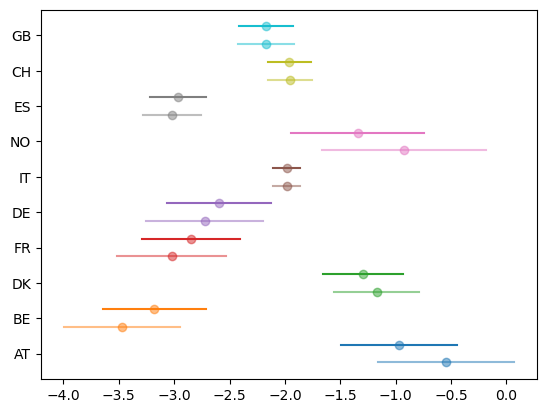

In [274]:
for i, r in enumerate(regions):
    plt.plot([CIs_ebci['lower_us'][i], CIs_ebci['upper_us'][i]],
             [2*i, 2*i], color='C%d'%i, alpha=0.5)
    plt.scatter(CIs_ebci['th_us'][i], 2*i, color='C%d'%i, alpha=0.5)
    plt.plot([CIs_ebci['lower_eb'][i], CIs_ebci['upper_eb'][i]],
             [2*i+1, 2*i+1], color='C%d'%i)
    plt.scatter(CIs_ebci['th_eb'][i], 2*i+1, color='C%d'%i, alpha=0.5)
plt.yticks(2*np.arange(len(regions))+0.5, regions)
plt.show()

In [263]:
CIs_ebci_sdw = \
results_ebci_sdw[['th_eb','len_eb','th_us','len_us']] \
.assign(upper_eb=lambda df: df.th_eb+df.len_eb,
        lower_eb=lambda df: df.th_eb-df.len_eb,
        upper_us=lambda df: df.th_us+df.len_us,
        lower_us=lambda df: df.th_us-df.len_us)
CIs_ebci_sdw

,th_eb,len_eb,th_us,len_us,upper_eb,lower_eb,upper_us,lower_us
0,-0.768841,0.439497,-0.541503,0.476684,-0.329345,-1.208338,-0.064819,-1.018187
1,-3.281707,0.411457,-3.473032,0.441586,-2.870250,-3.693164,-3.031446,-3.914618
2,-1.224962,0.276073,-1.173014,0.284725,-0.948889,-1.501034,-0.888290,-1.457739
3,-2.740370,0.605976,-3.021590,0.712305,-2.134394,-3.346346,-2.309286,-3.733895
4,-2.581301,0.517841,-2.726096,0.581085,-2.063460,-3.099141,-2.145011,-3.307180
5,-1.985030,0.235386,-1.982632,0.240688,-1.749644,-2.220416,-1.741944,-2.223320
6,-1.212779,0.574758,-0.926088,0.663924,-0.638022,-1.787537,-0.262164,-1.590012
7,-2.896642,0.401523,-3.021563,0.429401,-2.495119,-3.298165,-2.592162,-3.450964
8,-1.956318,0.203496,-1.953576,0.206895,-1.752822,-2.159813,-1.746682,-2.160471
9,-2.170520,0.148872,-2.172886,0.150189,-2.021648,-2.319392,-2.022697,-2.323075


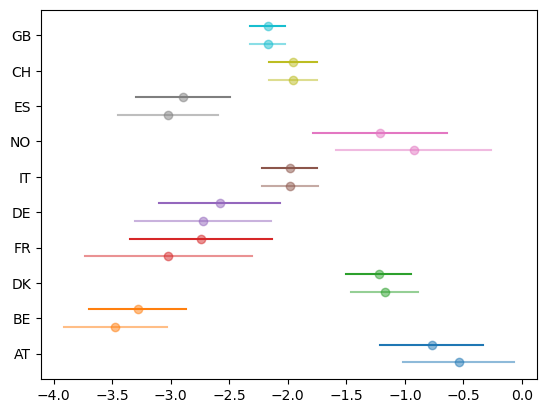

In [275]:
for i, r in enumerate(regions):
    plt.plot([CIs_ebci_sdw['lower_us'][i], CIs_ebci_sdw['upper_us'][i]],
             [2*i, 2*i], color='C%d'%i, alpha=0.5)
    plt.scatter(CIs_ebci_sdw['th_us'][i], 2*i, color='C%d'%i, alpha=0.5)
    plt.plot([CIs_ebci_sdw['lower_eb'][i], CIs_ebci_sdw['upper_eb'][i]],
             [2*i+1, 2*i+1], color='C%d'%i)
    plt.scatter(CIs_ebci_sdw['th_eb'][i], 2*i+1, color='C%d'%i, alpha=0.5)
plt.yticks(2*np.arange(len(regions))+0.5, regions)
plt.show()